# <center>Portfolio Project: Predicting<br>Risky Loans</center>
Welcome to my portfolio project, where I will build a model to predict trustworthiness of loaners. <br>
I will demonstrate the complete data processing pipeline, from data prepration, model fitting with different algorithms, model selection and parameter boosting. <br>
Thank you for your time and reviewing my portfolio! 

**Content:** <br>
1. [Data Info & Setup](#1.)<br>
    1.1 [Creating the Target Variable](#1.1)<br>
1. [Exploratory Data Analysis & Data Preparation](#2.)<br>
    2.1 [Text Columns & Feature Engineering](#2.1)<br>
    2.2 [Normalization](#2.2)<br>
    2.3 [Missing Data & KNN Imputation](#2.3)



<a id='1.'></a>

# 1. Data Info & Setup

This is a [publicly available data set](http://https://www.lendingclub.com/auth/login?login_url=%2Finfo%2Fdownload-data.action) from LendingClub, an American peer-to-peer lending company.  I will build a model to predict which loans had been paid back completely and without delay. This will provide valueable information for future loan decisions. 

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# Load the data
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


The file contains 2,260,701 loans and 151 variables describing each loan and customer. 

<a id='1.1'></a>

## 1.1 Creating the Target Variable
There is one variable informing about loan status.
Let's have a closer look: 

In [4]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

I will use loan_status to create a binary variable, which marks problematic 
loans. This will become my **target variable** for modeling. 

In [5]:
problematic_loans = ["Charged Off", "Default", "In Grace Period", 
                     "Does not meet the credit policy. Status:Charged Off", 
                     "Late (16-30 days)", "Late (31-120 days)"]

df["problematic_loan"] = df["loan_status"].apply(lambda s: int(s in problematic_loans))

In [6]:
# I drop all current loans from analysis. We don't know whether they will 
# become problamtic loans or not and I will therefore exclude them
df = df[df["loan_status"] != "Current"]

In [1]:
labels = "Problematic Loans", "Good Loans"
sizes = [df["problematic_loan"].sum()/len(df), 1 - df["problematic_loan"].sum()/len(df)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)

plt.show()

NameError: name 'df' is not defined

<a id='2.'></a>

# 2. Exploratory Data Analysis & Data Preparation

<a id='2.1'></a>

# 2.1 Text Columns & Feature Engineering

In [9]:
#List all text columns
for c in df.columns:
    if df[c].dtype  == "object":
        print(c, "has", df[c].nunique(), "unique values.")
        if df[c].nunique() < 11: 
                print(df[c].value_counts())

id has 1382384 unique values.
term has 2 unique values.
 36 months    1043059
 60 months     339292
Name: term, dtype: int64
grade has 7 unique values.
B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64
sub_grade has 35 unique values.
emp_title has 385454 unique values.
emp_length has 11 unique values.
home_ownership has 6 unique values.
MORTGAGE    682142
RENT        550448
OWN         149215
ANY            311
OTHER          182
NONE            53
Name: home_ownership, dtype: int64
verification_status has 3 unique values.
Source Verified    536031
Verified           429617
Not Verified       416703
Name: verification_status, dtype: int64
issue_d has 139 unique values.
loan_status has 8 unique values.
Fully Paid                                             1076751
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                         

### Creating dummy variables 
As we can see abosve, some text columns are binary. I inspected them further and decided to transform most of them to dummy varibles:

In [10]:
#Creating dummy variables from potentially interesting binary categorical variables: 
df = pd.get_dummies(df, columns=["term", "pymnt_plan", "application_type", "hardship_flag", 
                                 "debt_settlement_flag", 'disbursement_method'], drop_first=True)

### Feature Engineering

Through more exploration, I identified a few text columns with binary values. 3 text variables which have 
interesting information: <br>
- "purpose" indicates whether a customer already had prior debt
- "home_ownership" indicates whether someone owns a house with or without mortgage 
- "grade" refers to credit score grade <br>
<br>
I transform the first two variables into binary dummy variables and grade into a continuos variable. 

**Prior debt from purpose**

Text(0.5, 1.0, 'Prior Debt')

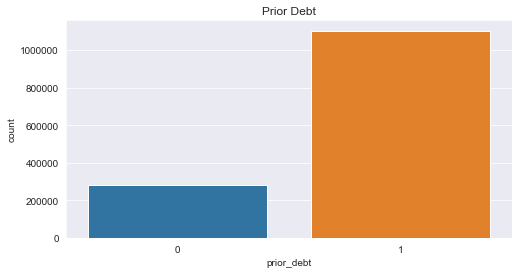

In [11]:
def check_prior_debt(s):
    if s in ["debt_consolidation", "credit_card"]:
        return 1
    else:
        return 0
    
df["prior_debt"] = df["purpose"].apply(check_prior_debt)

#Most loaners had prior debt: 
plt.figure(figsize=(8,4))
sns.countplot(df["prior_debt"])
plt.title("Prior Debt")

**Home ownership and mortgage**

Text(0.5, 1.0, 'Home ownership')

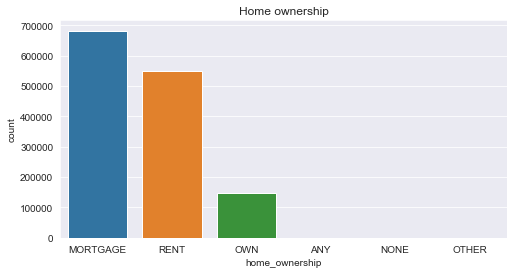

In [12]:
df["home_owner"] = df["home_ownership"].apply(lambda s: int(s == "OWN"))
df["mortgage"] = df["home_ownership"].apply(lambda s: int(s == "MORTGAGE"))

#Few loaners own a house without mortgage: 
plt.figure(figsize=(8,4))
sns.countplot(df["home_ownership"])
plt.title("Home ownership")

**Credit Card Score**

In [13]:
df["grade"].value_counts()

B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64

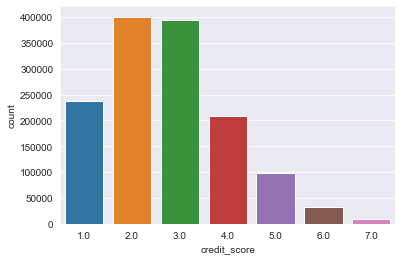

In [14]:
cs_convert = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "NaN": np.nan}
df["credit_score"] = df["grade"].apply(lambda s: cs_convert[s] if pd.notnull(s) else s)

sns.countplot(df[df["credit_score"].notnull()]["credit_score"])

### Delete text columns
After having engineered new features from some text columns and turned others into dummy variables, 
I will delete all text columns:

In [15]:
#Delete text columns irrelevant for modeling
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title', 'sub_grade', 'emp_title', 
         'emp_length', 'issue_d', 'purpose', 'addr_state', 'earliest_cr_line', 'last_pymnt_d',
         'next_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line', 'hardship_start_date',
         'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date', 
         'settlement_date', 'home_ownership', 'home_ownership', 'initial_list_status', 
         'hardship_type', 'hardship_reason', 'hardship_status', 'grade', 'verification_status', 
         'settlement_status','hardship_loan_status', 'verification_status_joint', 'loan_status'], 
        axis=1, inplace=True)

<a id='2.2'></a>

## 2.2 Normalization

Normalization is a process to put all features in a standard space (usually between 0 and 1). Most machine learning algorithms profit from normalization. It ensures that all features have equal weight or importance in the modeling process. Because I will employ a first machine learning algorithm when imputing missing data in the next section, it is now time to normalize the data.

In [28]:
df_norm = (df-df.min()) / (df.max()-df.min())

<a id='2.3'></a>

## 2.3 Missing Data & Imputation

### Missings per column 

Text(0.5, 0, 'Columns')

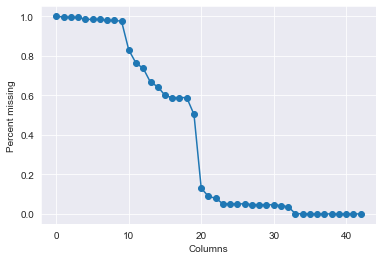

In [30]:
missings_column = df_norm.isnull().sum(axis=0).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/len(df_norm) for s in sorted(missings_column, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Columns")

There are columns with many missing but then there is a sudden drop from >50% to 13% missing rows. I will exclude all columns with more than 50% missing:

In [31]:
loans = df_norm.dropna(axis=1, thresh=len(df_norm)/2)

### Missings per row

Text(0.5, 0, 'Rows')

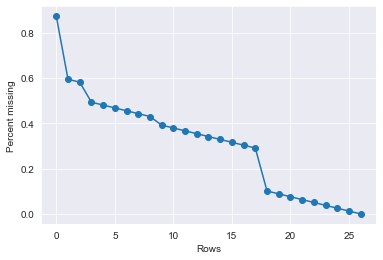

In [32]:
missings_row = loans.isnull().sum(axis=1).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/loans.shape[1] for s in sorted(missings_row, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Rows")

There is a jump from 9.6% to 27.7% missing in a row. As a rule of thumb, 
20-25% is an accepted standard to drop rows and I will follow this here. 
For a real-world data-set, it is normally wortwhile to have a closer look
at the missing values and see if there is possibility to complete the 
data set.

In [59]:
loans = loans.dropna(axis=0, thresh=0.75*loans.shape[1])

In [60]:
loans.to_csv("LoansData_beforeImputation.csv")

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [9]:
loans = pd.read_csv("LoansData_beforeImputation.csv", dtype=np.float16)
loans.drop(columns="Unnamed: 0", inplace=True)

In [10]:
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,term_ 60 months,pymnt_plan_y,application_type_Joint App,hardship_flag_Y,debt_settlement_flag_Y,disbursement_method_DirectPay,prior_debt,home_owner,mortgage,credit_score
0,0.078491,0.078491,0.090027,0.337891,0.068848,0.005001,0.006908,0.000000,0.276611,0.275391,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.333252
1,0.612793,0.612793,0.617676,0.260010,0.475342,0.005909,0.017059,0.025635,0.446777,0.444824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333252
2,0.493652,0.493652,0.500000,0.213013,0.249390,0.005726,0.011780,0.000000,0.361816,0.360107,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.166626
3,0.250732,0.250732,0.260010,0.667480,0.166138,0.009491,0.026367,0.025635,0.361816,0.360107,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.833496
4,0.289795,0.289795,0.298828,0.316650,0.233398,0.003092,0.011200,0.000000,0.340332,0.338867,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333252


In [15]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312075 entries, 0 to 1312074
Data columns (total 79 columns):
loan_amnt                        1312075 non-null float16
funded_amnt                      1312075 non-null float16
funded_amnt_inv                  1312075 non-null float16
int_rate                         1312075 non-null float16
installment                      1312075 non-null float16
annual_inc                       1312075 non-null float16
dti                              1311663 non-null float16
delinq_2yrs                      1312075 non-null float16
fico_range_low                   1312075 non-null float16
fico_range_high                  1312075 non-null float16
inq_last_6mths                   1312074 non-null float16
open_acc                         1312075 non-null float16
pub_rec                          1312075 non-null float16
revol_bal                        1312075 non-null float16
revol_util                       1311261 non-null float16
total_acc        

<a id='3.'></a>